In [1]:
%load_ext autoreload
%autoreload 2

# Start of Essential Cells

In [2]:
#@title **Location** of the dataset
path =  "../data/LendingClub/"
process_path = "../data/ProcessedData/"
save_path = "../tests/"
ri_datasets_path = "../data/riData/"
backup_image_folder = "../../backup/Images/"

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import secrets
import seaborn as sns
import joblib
import os
import re
import logging



from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from scipy.stats import ks_2samp
from lightgbm import LGBMClassifier
from pathlib import Path
from sklearn.metrics import (roc_auc_score)
from sklearn.model_selection import KFold
from sklearn.impute import KNNImputer
from sklearn.feature_selection import r_regression


In [4]:
from sklearn.metrics import (accuracy_score, balanced_accuracy_score,
                            f1_score, precision_score, recall_score,
                            roc_auc_score, roc_curve)

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.semi_supervised import LabelSpreading

In [6]:
import credit_pipeline.data_exploration as dex
import credit_pipeline.training as tr
import credit_pipeline.reject_inference as ri
import credit_pipeline.evaluate as ev

from submodules.topsis_python import topsis as top

[x] add kfold

[x] add topsis/ahp multicriterio

[x] add criterio de parada

[-] pip freeze

In [7]:
#@title Set seed
new_seed = False #@param {type:"boolean"}

if new_seed:
    seed_number = secrets.randbelow(1_000) #to name the results files

    while seed_number <100:
        seed_number = secrets.randbelow(1_000)
else:
    seed_number = 42050

main_seed = seed_number
print(seed_number)

42050


In [8]:
logpath = Path(os.path.join(ri_datasets_path,f'note23/{main_seed}_log.txt'))
logpath.parent.mkdir(parents=True, exist_ok=True)


# Configure logging to file
logging.basicConfig(filename=logpath, 
                    filemode='w',  # Overwrite the file each time the application runs
                    level=logging.DEBUG,  # Capture all levels of logging
                    format='%(asctime)s - %(levelname)s - %(message)s',  # Include timestamp, log level, and message
                    datefmt='%Y-%m-%d %H:%M:%S')  # Format for the timestamp


#Read Dataset

In [9]:
ls '../data/LendingClub/'

accepted_2007_to_2018Q4.csv  LCDataDictionary.xlsx  rejected_2007_to_2018Q4.csv


In [105]:
import pandas as pd
import os

# Specify the directory where your CSV files are located
directory = Path(os.path.join(ri_datasets_path, f'metrics_bm/test/'))

years = ["2009", "2010", "2011", "2012",]
# Loop through each file in the directory

auc_dict = {}
year_dict = {}
for year in years:
    year_list = []
    for filename in os.listdir(directory):
        if filename.endswith(".csv"):
            # Construct the full file path
            filepath = os.path.join(directory, filename)
            
            # Read the CSV file into a DataFrame
            df = pd.read_csv(filepath)
            # df['Year'] = filename[-8:-4]
            df.rename(columns={'Unnamed: 0':'Metrics'}, inplace=True)
            df = df.iloc[[0,7,8],:]

            # Now you can do processing with df (which is your data frame)
            # For example, you can print the first few rows of each file
            if filename[-8:-4] == year:
                # print(f"First few rows of {filename}:")
                year_list.append(df)
    year_df = pd.concat(year_list)
    year_dict[year] = year_df
    auc = year_df.query('Metrics == "AUK"')
    dfauc = auc.iloc[:,1:].mean(axis=0)
    dfauc = pd.DataFrame(dfauc, columns = ["AUK"])
    dfauc= dfauc.T
    try:
        dfauc['Only Acp'] = dfauc['BM']
        dfauc['A-Soft Cut-Off'] = dfauc['A-SC']
        dfauc['A-Upward'] = dfauc['A-UW']
        dfauc['A-Fuzzy'] = dfauc['A-FU']
        dfauc['Extrapolation'] = dfauc['E-C']
        dfauc['Parcelling'] = dfauc['PAR']
        dfauc['Label Spreading'] = dfauc['LSP']
        dfauc['CI-EX'] = dfauc['TN']
        dfauc['CI-LS'] = dfauc['TN+']
        dfauc = dfauc.drop(['BM', 'A-SC', 'A-UW', 'A-FU', 'E-C', 'PAR', 'LSP', 
                                            'TN', 'TN+'], axis=1)

    except Exception as e:
        print(e)
    df_auc = dfauc.T

    df_auc.insert(0, 'Models', df_auc.index)
    df_auc = df_auc.round(3)
    df_auc
    auc_dict[year] = df_auc



In [114]:
year_dict['2012'].groupby('Metrics').mean().round(3).to_latex()

'\\begin{tabular}{lrrrrrrrrr}\n\\toprule\n & BM & A-SC & A-UW & A-FU & E-C & PAR & LSP & TN & TN+ \\\\\nMetrics &  &  &  &  &  &  &  &  &  \\\\\n\\midrule\nAUC & 0.890000 & 0.890000 & 0.890000 & 0.884000 & 0.883000 & 0.881000 & 0.880000 & 0.887000 & 0.863000 \\\\\nAUK & 0.002000 & -0.003000 & 0.002000 & -0.020000 & -0.031000 & -0.024000 & 0.028000 & 0.019000 & 0.200000 \\\\\nKickout & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 0.021000 & 0.245000 \\\\\n\\bottomrule\n\\end{tabular}\n'

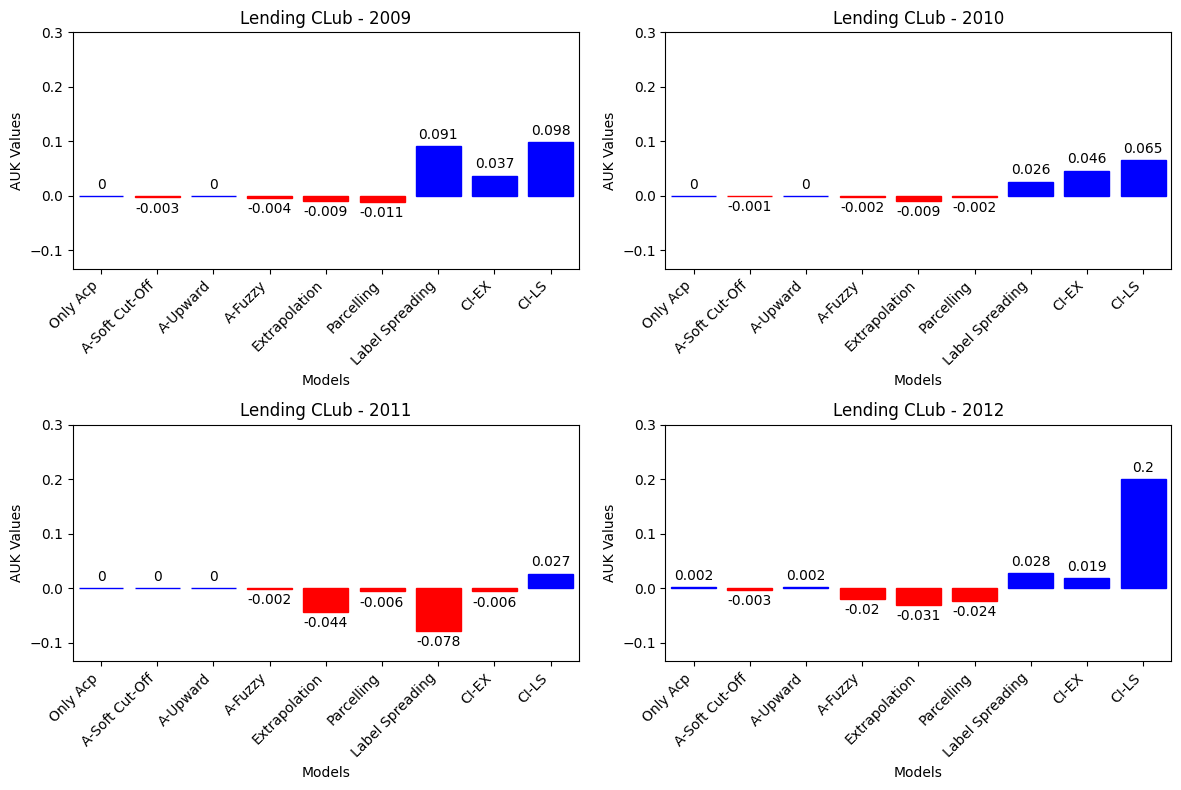

In [98]:
# Create a figure with four axes
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Iterate over the years and corresponding dataframes
for i, (year, df) in enumerate(auc_dict.items()):
    # Get the corresponding axis
    norm = plt.Normalize(df['AUK'].min(), df['AUK'].max())
    sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
    sm.set_array([])

    ax = axes[i // 2, i % 2]
    
    # Plot the dataframe on the axis
    sns.barplot(data=df, x='Models', y='AUK', estimator=sum, errorbar=None, ax=ax)
    for i, bar in enumerate(ax.patches):
        # bar.set_color(sm.to_rgba(df['AUK'].iloc[i]))
        if df['AUK'].iloc[i] < 0:
            bar.set_color('red')
        else:
            bar.set_color('blue')
    # Customize the plot
    ax.bar_label(ax.containers[0], fontsize=10, padding=3)
    ax.set_xticks(ax.get_xticks()[::1])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    ax.set_xlabel('Models')
    ax.set_ylabel('AUK Values')
    ax.set_title(f'Lending CLub - {year}')
    ax.set_ylim(top=0.3, bottom=-0.134)

# Adjust the layout and save the figure
plt.tight_layout()
plt.savefig(f'{ri_datasets_path}LC/mean_AUK', dpi=350)
plt.show()


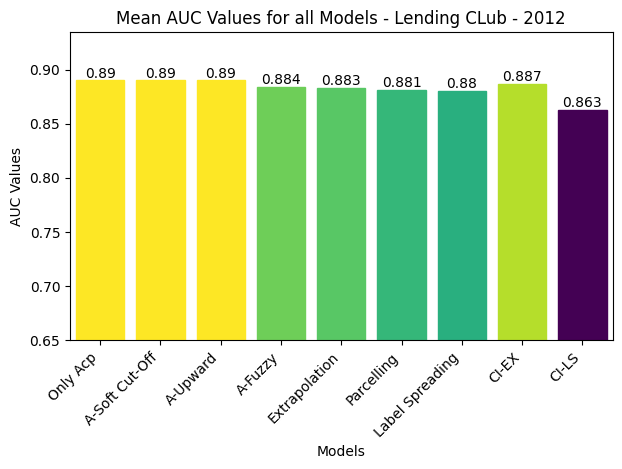

In [67]:
# Plotting
plt.figure(figsize=(7, 4))

norm = plt.Normalize(df_auc['AUC'].min(), df_auc['AUC'].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])

ax = sns.barplot(data=df_auc, x='Models', y='AUC', estimator=sum, errorbar=None)
for i, bar in enumerate(ax.patches):
    bar.set_color(sm.to_rgba(df_auc['AUC'].iloc[i]))
# lineplot = sns.lineplot(x='Models', y='Overall AUC', data=df_auc, marker='o', color='red', sort=False, label='auc')

# Labeling each bar
ax.bar_label(ax.containers[0], fontsize=10)
ax.set_xticks(ax.get_xticks()[::1])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_xlabel('Models')
ax.set_ylabel('AUC Values')
ax.set_title(f'Mean AUC Values for all Models - Lending CLub - {year}')
# ax.set_title(f'Mean AUC Values for all Models. P value = {p}')
# ax.legend()
plt.ylim(bottom=0.65)

plt.savefig(f'{ri_datasets_path}LC/mean_auc_{year}',  dpi=350)
plt.show()


In [55]:
f'{ri_datasets_path}LC/mean_auc_{year}'

'../data/riData/LC/mean_auc_2012'